# Библиотеки

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_training
import plotting_utils

In [2]:
# run this function if you need to generate a csv data set from scratch
# data_loader.generate_csv_dataset()

In [2]:
# X, y, ID = data_loader.load_dataset(X_path='data/feature_vector_based_mean_mfcc_and_std_mfcc_nfft_8192.csv', 
#                                     y_path='data/y_labels_8192.csv',
#                                     ID_path='data/IDs_8192.csv')

# X, y, ID = data_loader.load_dataset(X_path='data/feature_vector_based_mean_mfcc_and_std_mfcc_nfft_16384.csv', 
#                                     y_path='data/y_labels_16384.csv',
#                                     ID_path='data/IDs_16384.csv')

X, y, ID = data_loader.load_dataset(X_path='data/feature_vector_based_mean_mfcc_and_std_mfcc_nfft_4096_vad.csv', 
                                    y_path='data/y_labels_4096.csv',
                                    ID_path='data/IDs_4096.csv')

data loaded in 0.036536455154418945ms
          0         1         2         3         4         5         6  \
0  1.262064  0.559099  1.127202  1.028767  0.782628  0.416169  0.922876   
1  0.619353  0.271546  1.415962  1.036916  0.646731  0.879723  0.623126   
2  1.612653  0.491839  1.199638  0.718815  0.823601  0.625229  0.427912   
3  0.633679  0.681817  0.774481  0.872321  1.085673  0.850478  0.248430   
4  1.880823  0.701174  1.516193  1.016059  0.986903  0.396255  0.752020   

          7         8         9  ...        68        69        70        71  \
0 -1.030790 -0.437691  0.988884  ... -1.057626 -0.709507 -0.966676 -0.904106   
1 -0.789153  0.103614  1.001272  ... -0.851054 -0.696531 -1.182908 -0.810364   
2 -0.906554 -0.796344  1.040167  ... -1.282965 -1.147002 -1.026193 -0.951325   
3 -0.499117 -0.497405  1.093443  ... -0.710971 -0.935751 -0.511684 -0.856036   
4 -0.763887 -1.002145  0.951467  ... -0.991594 -1.116439 -1.191915 -0.740528   

         72        73        7

In [26]:
ID['0'].unique()    # actors

array([22,  9, 18,  6, 24,  3, 21, 12, 14, 15,  5, 20, 23,  4,  8, 13, 11,
       10,  7,  2, 19,  1, 17, 16])

In [3]:
group_members= data_loader.get_k_fold_group_member()


X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X, y, ID, group_members)
print(len(X_k_folds))

5


## SVM with Linear kernel

### Train & evaluate function

### Grid Search (C)

100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


UAR = 0.404


100%|██████████| 5/5 [00:00<00:00,  8.40it/s]


UAR = 0.415


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


UAR = 0.413


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


UAR = 0.420


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


UAR = 0.413


100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


UAR = 0.395


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


UAR = 0.396


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


UAR = 0.390


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


UAR = 0.386


100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


UAR = 0.379


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


UAR = 0.370


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

UAR = 0.365


Text(0, 0.5, 'UAR')

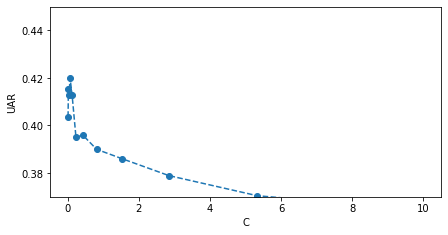

In [4]:
# C = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1.0, 2.0, 3.0]
C = np.logspace(-2, 1, 12, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5))
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.45])
plt.xlabel('C')
plt.ylabel('UAR')

In [5]:
10**(C_best)

NameError: name 'C_best' is not defined

## Results and confusion matrix

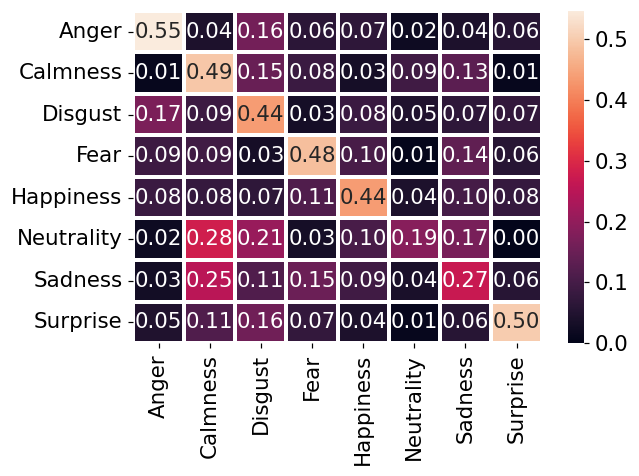

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [6]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# SVM (version 2)

In [7]:
# C = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1.0, 2.0, 3.0, 10.0]
C = np.logspace(-2, 0.5, 10, endpoint=True)
UAR_list = []
UAR_best = 0
C_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C, decision_function_shape='ovr',break_ties=True)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te        
        C_best = val_C
    UAR_list.append(UAR)

print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.6f}')

100%|██████████| 5/5 [00:00<00:00,  7.40it/s]


UAR = 0.404


100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


UAR = 0.418


100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


UAR = 0.413


100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


UAR = 0.423


100%|██████████| 5/5 [00:00<00:00,  7.48it/s]


UAR = 0.418


100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


UAR = 0.406


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


UAR = 0.402


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


UAR = 0.398


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


UAR = 0.384


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

UAR = 0.389
UAR_best = 0.423, C_best = 0.068129


## Plot GridSearch results

UAR_best = 0.423, C_best = 0.068


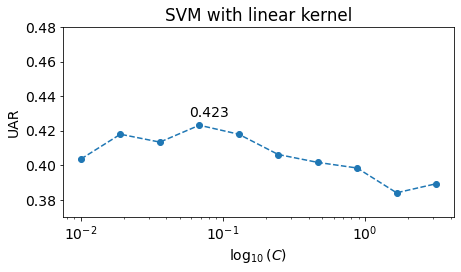

In [8]:
fig,ax=plt.subplots(figsize=(7,3.5))
plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
plt.xlabel('$\log_{10}(C)$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

In [36]:
10**(C_best)

1.0508587552139304

## Results and confusion matrix

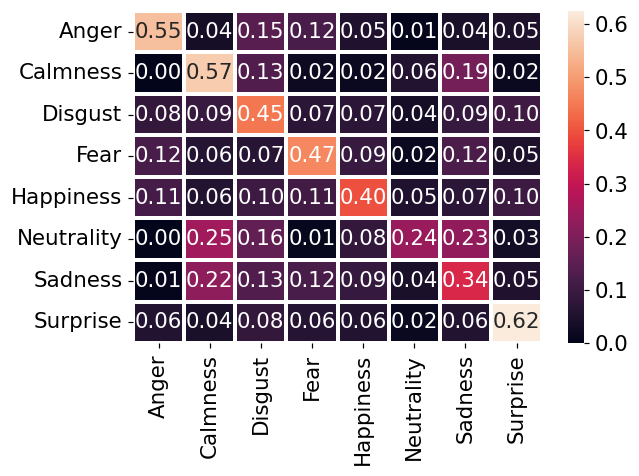

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [9]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)